# Masked Multi-Head Attention の仕組みと実装

## 1. はじめに
ここでは、TransformerモデルやGPT（Generative Pre-trained Transformer）で使用されている**Masked Multi-Head Attention**について解説します。

### 「マスク」の必要性
TransformerのDecoderは、翻訳タスクなどで**次の単語を予測する（自己回帰的な）**役割を持ちます。

例えば、「I am a student」という文を生成する場合、 モデルが「am」という単語を予測する時点では、モデルは「I」しか知っていてはいけません。もし、「student」という未来の単語が見えてしまうと、予測の学習になりません。

- EncoderのAttention: 文全体（過去も未来も）を見て、文脈を理解する。

- DecoderのMasked Attention: 現在位置より未来の単語は見ないように隠す。

## 2. マスクの仕組み
通常のAttentionのスコア計算式：
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)
V$$
Masked Attentionでは、Softmaxをかける直前の $QK^T$（Attention Score）に対して、未来の情報の位置に $-\infty$（マイナス無限大） を加算します。

Masked Attentionのスコア計算式：
$$\text{MaskedAttention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}} + M\right)V$$
この場合は $M$ がマスク行列です。

$$M = \begin{pmatrix}
0 & 1 & 1 & 1 \\
0 & 0 & 1 & 1 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0
\end{pmatrix}$$

Softmax関数は $e^x$ を計算するため、入力が $-\infty$ になると、その出力（確率）は限りなく 0 になり、未来の単語への注意（Attention Weight）を強制的にゼロにすることができます。


## 3. 実装による確認

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# 設定
d_k = 64  # 次元の大きさ
seq_len = 5 # 系列長（単語数）: 例「I am a student .」

# 1. ダミーのQueryとKeyを作成（ランダムな値）
torch.manual_seed(42)
Q = torch.randn(1, seq_len, d_k)
K = torch.randn(1, seq_len, d_k)

# 2. Attention Scoreの計算 (QK^T / sqrt(d_k))
scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k))

print("マスク適用前のスコア（一部）:")
print(scores[0])

マスク適用前のスコア（一部）:
tensor([[ 1.2097, -0.2490, -0.7624, -0.9953,  0.0542],
        [-0.2159,  0.6041, -1.6504, -1.0610,  1.8760],
        [ 1.4615, -0.4097, -1.0089, -0.9903,  0.8221],
        [ 1.5057, -1.1797,  0.6592, -1.8099,  0.5209],
        [ 0.9950,  0.5212,  0.6271, -0.5107,  0.3153]])


### マスク行列の作成
未来の情報（行列の上三角部分）を隠すためのマスクを作成します。
この際torch.tril (triangle lower) や torch.triu (triangle upper) を使うと簡単に作成できます。

ここでは、「見えてはいけない場所」を True (または大きなマイナスの値) にする手法をとります。

マスク行列 (Trueが隠す場所):
tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


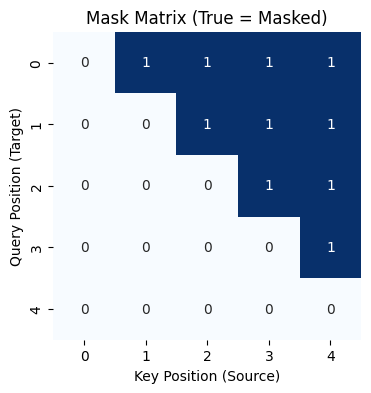

In [8]:
# 3. マスクの作成
# 上三角行列（対角成分を含まない）を作成し、そこを「隠すべき場所」とする
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()

print("マスク行列 (Trueが隠す場所):")
print(mask)

# 可視化
plt.figure(figsize=(5, 4))
sns.heatmap(mask, annot=True, cbar=False, cmap="Blues", square=True)
plt.title("Mask Matrix (True = Masked)")
plt.xlabel("Key Position (Source)")
plt.ylabel("Query Position (Target)")
plt.show()

この図の行（縦）は「現在処理している単語（Query）」、列（横）は「注意を向ける先（Key）」を表します。例えば、2番目の単語（Index 1） を処理する際は、0番目と1番目は見ても良い（False/青）ですが、2番目以降の未来（Index 2, 3, 4）は見えなくなっている（True/白）ことがわかります。

マスクの適用とSoftmax実際にスコアにマスクを適用（$-\infty$ で埋める）し、Softmaxを通して確率を確認します。

マスク適用後のスコア（上三角が非常に小さい値になる）:
tensor([[ 1.2097e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-2.1594e-01,  6.0405e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 1.4615e+00, -4.0967e-01, -1.0089e+00, -1.0000e+09, -1.0000e+09],
        [ 1.5057e+00, -1.1797e+00,  6.5922e-01, -1.8099e+00, -1.0000e+09],
        [ 9.9499e-01,  5.2116e-01,  6.2715e-01, -5.1068e-01,  3.1531e-01]])

最終的なAttention Weights:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3058, 0.6942, 0.0000, 0.0000, 0.0000],
        [0.8074, 0.1243, 0.0683, 0.0000, 0.0000],
        [0.6521, 0.0445, 0.2797, 0.0237, 0.0000],
        [0.3286, 0.2046, 0.2274, 0.0729, 0.1665]])


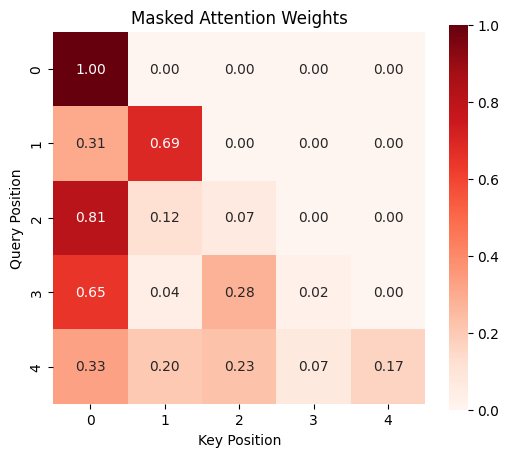

In [9]:
# 4. スコアにマスクを適用
# maskがTrueの場所を -1e9 (マイナス無限大に近い値) に置き換える
masked_scores = scores.masked_fill(mask, -1e9)

print("マスク適用後のスコア（上三角が非常に小さい値になる）:")
print(masked_scores[0])

# 5. Softmaxで確率に変換
attention_weights = F.softmax(masked_scores, dim=-1)

print("\n最終的なAttention Weights:")
print(attention_weights[0])

# 可視化
plt.figure(figsize=(6, 5))
sns.heatmap(attention_weights[0].detach(), annot=True, fmt=".2f", cmap="Reds", square=True)
plt.title("Masked Attention Weights")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()

### 結果の考察
上の図を見てみると、対角線より右上の成分（未来の単語へのAttention）がすべて 0.00 になっていることが確認できます。

また、1行目（最初の単語）は、1列目（自分自身）しか見ておらず、最後の行（最後の単語）では、すべての単語を見ることができます。

これが Masked Multi-Head Attention です。<br>
この仕組みにより、TransformerのDecoderは「答えを見ずに」次々と単語を予測する学習が可能になります。